In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pywt
from scipy import signal
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
a = np.array([1,5,11,9,13,21])
b = signal.resample(a, len(a) * 2)
b_int = b.astype(int)

In [ ]:
b_int = signal.resample_poly(a,2,1)

In [ ]:
b_int

array([ 1.00051747,  2.6072553 ,  5.00258735,  8.11101494, 11.00569218,
       11.46721121,  9.00465724,  7.95948506, 13.00672712, 20.63586664,
       21.01086688, 11.1091858 ])

# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


103

In [ ]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [ ]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
skip = window_size

for person in range(5,6):
  print('Person No.' + str(person))
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<5] = 0
  label[label>=5] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(40):
    sig = eeg[i][:32, :]
    sig = baseline_remove(sig)
    # Segmenting into 3 seconds (384 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      for j in range(32):
        temp = []
        coeffs = pywt.wavedec(sig[j, start:start+window_size], 'db1', level=1)
        cA1, cD1 = coeffs
        coeffs = pywt.wavedec(cA1, 'db1', level=1)
        cAA2, cAD2 = coeffs
        coeffs = pywt.wavedec(cD1, 'db1', level=1)
        cDA2, cDD2 = coeffs
        temp.append(signal.resample_poly(cAA2,4,1))
        temp.append(signal.resample_poly(cAD2,4,1))
        temp.append(signal.resample_poly(cDA2,4,1))
        temp.append(signal.resample_poly(cDD2,4,1))
        temp = np.asarray(temp, dtype = np.float32)
        temp = np.reshape(temp,[-1,window_size])
        eeg_signal.append(temp.T)
      valence.append(val[i])
      arousal.append(aro[i])
      start += skip 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,32,window_size,4])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.5
(1200, 32, 256, 4)
(1200,) (480,) (720,)
(1200,) (630,) (570,)


0

# **Proposed Architecture**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# **2D CNN NET**

In [ ]:
def channel_wise_attention(x):
  y = AvgPool2D(pool_size=(1,256))(x)
  y = Flatten()(y)
  y = Dense(5,activation='tanh') (y)
  y = Dense(32,activation='softmax') (y)
  x = Multiply()([x, tf.expand_dims(tf.expand_dims(y, axis=2), axis=2)])
  return x

def simple_2D_CNN(x):
  x = channel_wise_attention(x)
  x = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  x = MaxPool2D(pool_size=2)(x)
  
  x = Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = 'same', activation='selu')(x)
  x = MaxPool2D(pool_size=2)(x)

  x = Conv2D(filters = 64, kernel_size = 7, strides = 1, padding = 'same', activation='selu')(x)
  x = MaxPool2D(pool_size=2)(x)

  x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  x = MaxPool2D(pool_size=2)(x)

  x = Conv2D(filters = 96, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=2)(x)
  #x = Reshape((x.shape[2],x.shape[3]))(x)

  #x = MultiHeadAttention(num_heads=8, key_dim=64, value_dim=64)(x, x)

  x = Dropout(0.1)(x)

  x = Flatten()(x)
  x = Dense(512, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(256, activation='elu')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model() :
  input_shape = (data.shape[1], data.shape[2], data.shape[3])
  a = Input(input_shape)
  out = simple_2D_CNN(a)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=1e-04)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model

model = get_model()
model.summary()

Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 32, 256, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 average_pooling2d_6 (AveragePo  (None, 32, 1, 4)    0           ['input_53[0][0]']               
 oling2D)                                                                                         
                                                                                                  
 flatten_51 (Flatten)           (None, 128)          0           ['average_pooling2d_6[0][0]']    
                                                                                           

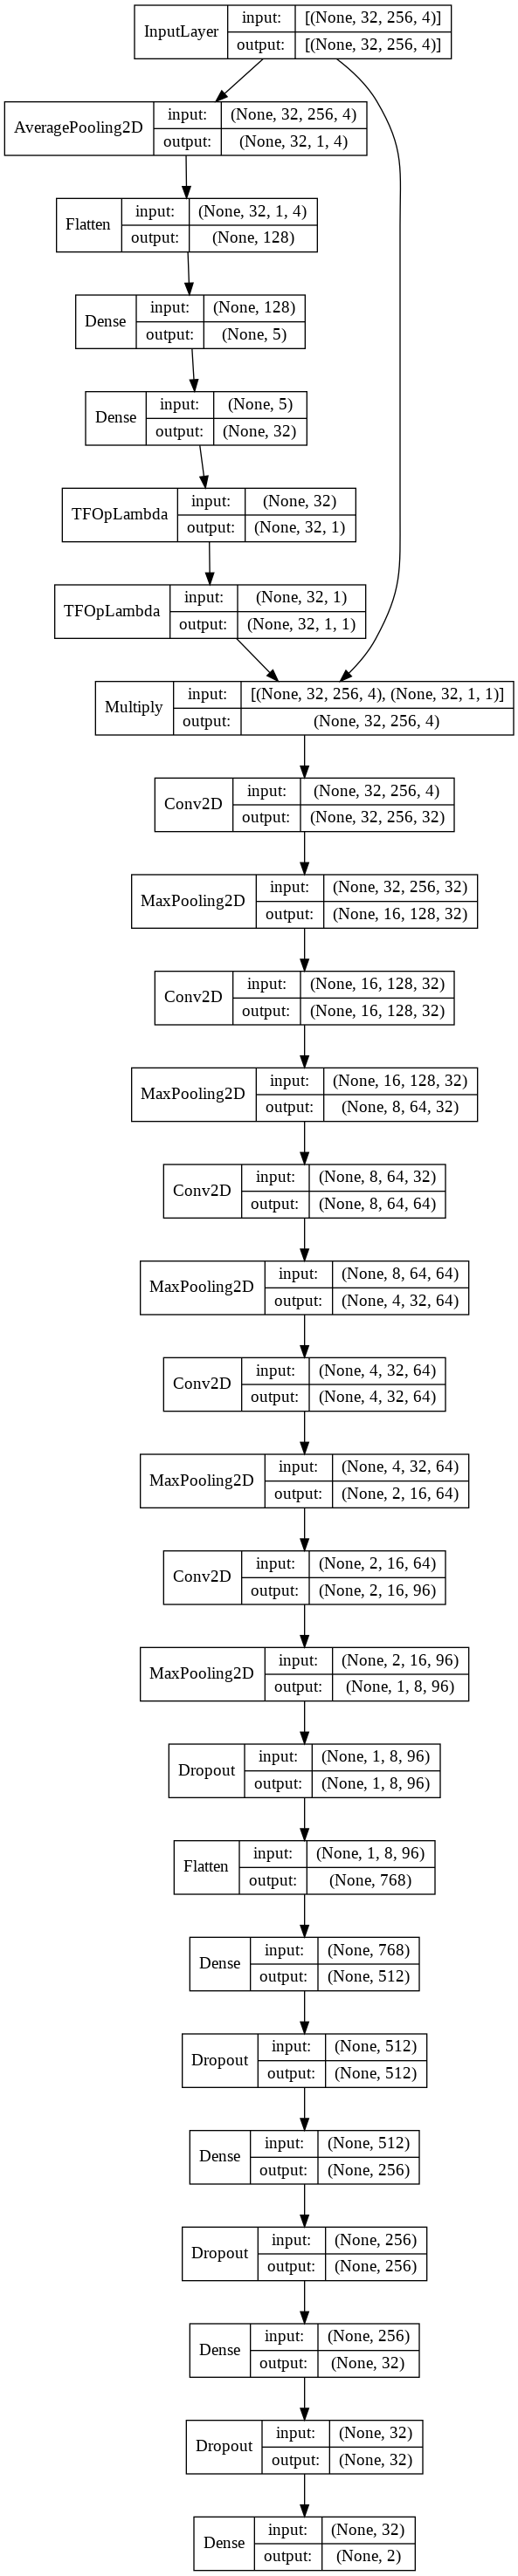

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
def dilation_1DCNN_block(x, dilation_rate):
  initializer = tf.keras.initializers.LecunNormal()
  y = Conv1D(filters=8, kernel_size=7, strides=1, padding='causal', dilation_rate=dilation_rate, activation='selu', 
             kernel_initializer=initializer)(x)
  y = Conv1D(filters=8, kernel_size=7, strides=1, padding='causal', dilation_rate=dilation_rate, activation='selu', 
             kernel_initializer=initializer)(y)
  return y

def causal_dilation_1DCNN_block(x):
  initializer = tf.keras.initializers.LecunNormal()
  x = Conv1D(filters=8, kernel_size=11, strides=1, padding='causal', dilation_rate=1, activation='selu', 
             kernel_initializer=initializer)(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Conv1D(filters=8, kernel_size=11, strides=1, padding='causal', dilation_rate=1, activation='selu', 
             kernel_initializer=initializer)(x)
  x = MaxPool1D(pool_size=2)(x)
  y1 = dilation_1DCNN_block(x, 1)
  x = MaxPool1D(pool_size=2)(x)
  y1 = MaxPool1D(pool_size=2)(y1)
  y2 = dilation_1DCNN_block(Add()([x, y1]), 2)
  y3 = dilation_1DCNN_block(Add()([y1, y2]), 4)
  y4 = dilation_1DCNN_block(Add()([y2, y3]), 8)
  x = Add()([y1, y2, y3, y4])
  x = MaxPool1D(pool_size=2)(x)
  x = Dropout(0.1)(x)
  x = Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', dilation_rate=1, activation='selu', 
             kernel_initializer=initializer)(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Conv1D(filters=16, kernel_size=5, strides=1, padding='causal', dilation_rate=1, activation='tanh', 
             kernel_initializer=initializer)(x)
  x = Dropout(0.1)(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Flatten()(x)
  return x

def parallel_1D_CNN(x):
  x1 = causal_dilation_1DCNN_block(x[:,0,:,:])
  x2 = causal_dilation_1DCNN_block(x[:,1,:,:])
  x1 = Concatenate()([x1, x2])
  for i in range(2, x.shape[1]):
    x2 = causal_dilation_1DCNN_block(x[:,i,:,:])
    x1 = Concatenate()([x1, x2])
  x = Reshape((x.shape[1], x2.shape[1], 1))(x1)
  x = Conv2D(filters = 8, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  x = MaxPool2D(pool_size=2)(x) 
  x = Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', activation='selu')(x)
  x = MaxPool2D(pool_size=2)(x)
  x = Conv2D(filters = 32, kernel_size = 7, strides = 1, padding = 'same', activation='selu')(x)
  x = MaxPool2D(pool_size=2)(x)
  x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  x = MaxPool2D(pool_size=2)(x)

  x = Dropout(0.1)(x)

  x = Flatten()(x)
  x = Dense(256, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model() :
  input_shape = (data.shape[1], data.shape[2], 1)
  a = Input(input_shape)
  out = parallel_1D_CNN(a)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=1e-04)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model

model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 256, 1)      0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 256, 1)      0           ['input_1[0][0]']                
 icingOpLambda)                                                                               

In [ ]:
def simple_2D_CNN(x):
  x = Bidirectional(LSTM(8, return_sequences=True))(x)
  x = Dropout(0.1)(x)
  x = Bidirectional(LSTM(4, return_sequences=True))(x)
  x = Dropout(0.1)(x)
  x = Bidirectional(LSTM(2, return_sequences=True))(x)
  x = Dropout(0.1)(x)
  #x = Bidirectional(LSTM(8, return_sequences=True))(x)
  #x = Dropout(0.1)(x)
  #x = Reshape((x.shape[1], x.shape[2],1))(x)

  x = Flatten()(x)
  x = Dense(512, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(256, activation='elu')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model() :
  input_shape = (data.shape[1], data.shape[2])
  a = Input(input_shape)
  out = simple_2D_CNN(a)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=1e-06)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model

model = get_model()
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256, 32)]         0         
                                                                 
 bidirectional_51 (Bidirecti  (None, 256, 16)          2624      
 onal)                                                           
                                                                 
 dropout_79 (Dropout)        (None, 256, 16)           0         
                                                                 
 bidirectional_52 (Bidirecti  (None, 256, 8)           672       
 onal)                                                           
                                                                 
 dropout_80 (Dropout)        (None, 256, 8)            0         
                                                                 
 bidirectional_53 (Bidirecti  (None, 256, 4)           176

In [ ]:
def get_CDB_model() :
  input_shape = (data.shape[1], data.shape[2],1)
  a = Input(input_shape)
  out = causal_dilation_1DCNN_block(a[:, 0, :, :])
  model = Model(a, out)
  return model

m = get_CDB_model()
m.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.__operators__.getitem_32 (S  (None, 256, 1)      0           ['input_2[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 conv1d_384 (Conv1D)            (None, 256, 8)       96          ['tf.__operators__.getitem_32[0][
                                                                 0]']                       

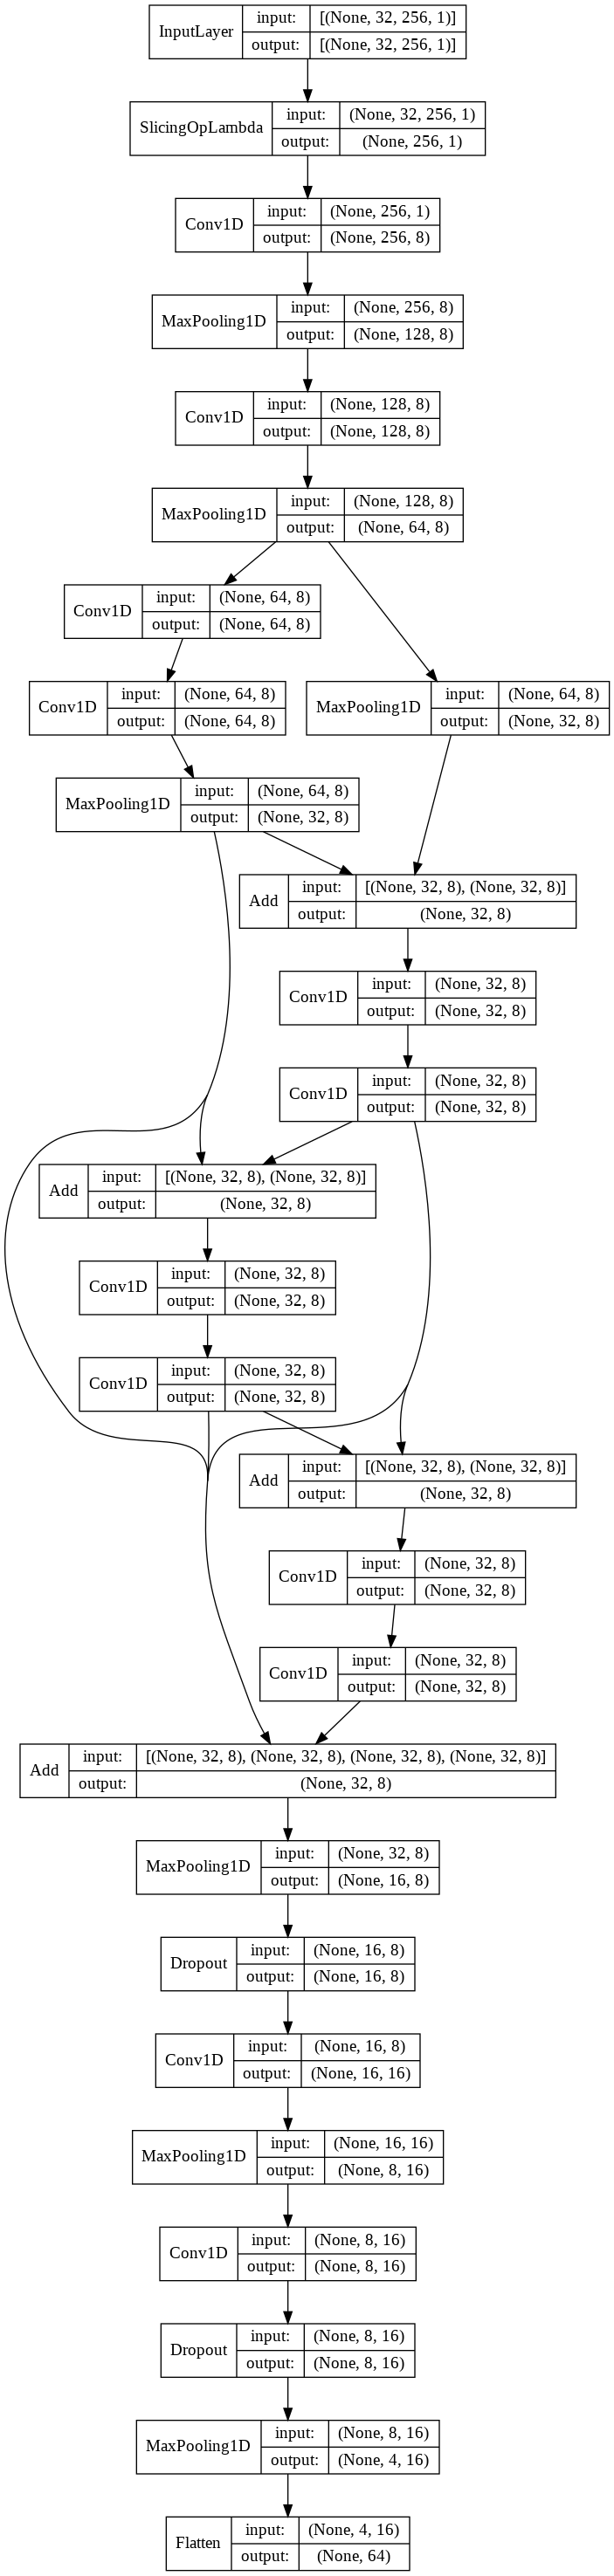

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(m, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
batch_size = 32
epochs = 100
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

38705

In [ ]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 4) (120, 32, 256, 4) (1080, 2) (120, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/100
31/31 [==============================] - 5s 128ms/step - loss: 0.7176 - accuracy: 0.5165 - val_loss: 0.6689 - val_accuracy: 0.6852
Epoch 2/100
31/31 [==============================] - 4s 126ms/step - loss: 0.6697 - accuracy: 0.5844 - val_loss: 0.6325 - val_accuracy: 0.7593
Epoch 3/100
31/31 [==============================] - 4s 124ms/step - loss: 0.5951 - accuracy: 0.7160 - val_loss: 0.5750 - val_accuracy: 0.7130
Epoch 4/100
31/31 [==============================] - 4s 123ms/step - loss: 0.5101 - accuracy: 0.7747 - val_loss: 0.4765 - val_accuracy: 0.8333
Epoch 5/100
31/31 [==============================] - 4s 122ms/step - loss: 0.4001 - accuracy: 0.8272 - val_loss: 0.3955 - val_accuracy: 0.8704
Epoch 6/100
31/31 [==============================] - 4s 122ms/step - loss: 0.2534 - accuracy: 0.9208 - val_loss: 0.3227 - val_accuracy: 0.8981
Epoch 7/100
31/31 [==============================] - 4s 123ms/step - loss: 0.1624 - accuracy: 0.9630 - val_loss: 0.2664 - v

In [ ]:
acc = model.evaluate(x_test, y_test)
print(acc)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
print(f1scr)
cnfsn = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print(cnfsn)

4/4 [==============================] - 0s 20ms/step - loss: 0.0939 - accuracy: 0.9750
[0.09394004940986633, 0.9750000238418579]
0.9738656987295826
[[46  3]
 [ 0 71]]


Accuracy  : 0.951666659116745
F1_Score  : 0.9492911154382592


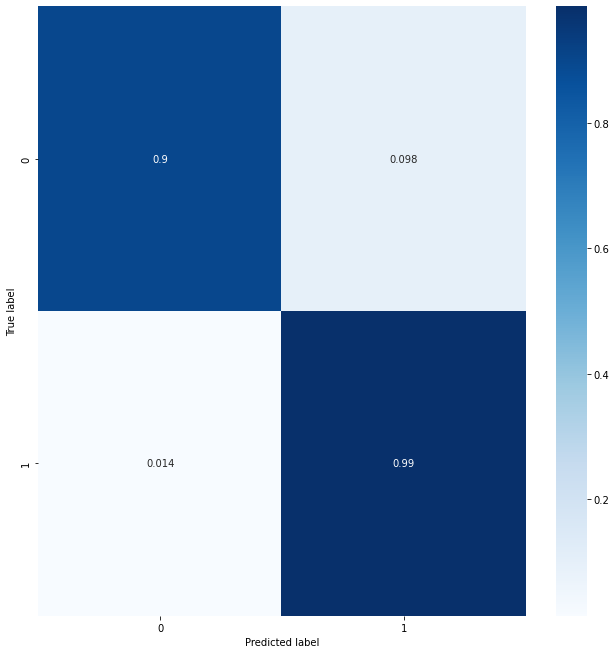

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1080, 32, 256, 4) (120, 32, 256, 4) (1080, 2) (120, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/100
31/31 [==============================] - 5s 118ms/step - loss: 0.7228 - accuracy: 0.5134 - val_loss: 0.6683 - val_accuracy: 0.5741
Epoch 2/100
31/31 [==============================] - 3s 112ms/step - loss: 0.6735 - accuracy: 0.5905 - val_loss: 0.6344 - val_accuracy: 0.7130
Epoch 3/100
31/31 [==============================] - 3s 110ms/step - loss: 0.5991 - accuracy: 0.7016 - val_loss: 0.5891 - val_accuracy: 0.6852
Epoch 4/100
31/31 [==============================] - 4s 113ms/step - loss: 0.4741 - accuracy: 0.8025 - val_loss: 0.4830 - val_accuracy: 0.7593
Epoch 5/100
31/31 [==============================] - 3s 111ms/step - loss: 0.3221 - accuracy: 0.8837 - val_loss: 0.2871 - val_accuracy: 0.8981
Epoch 6/100
31/31 [==============================] - 3s 112ms/step - loss: 0.1639 - accuracy: 0.9537 - val_loss: 0.2526 - val_accuracy: 0.8981
Epoch 7/100
31/31 [==============================] - 3s 111ms/step - loss: 0.0857 - accuracy: 0.9815 - val_loss: 0.1772 - v

Accuracy  : 0.9541666567325592
F1_Score  : 0.9538620111419285


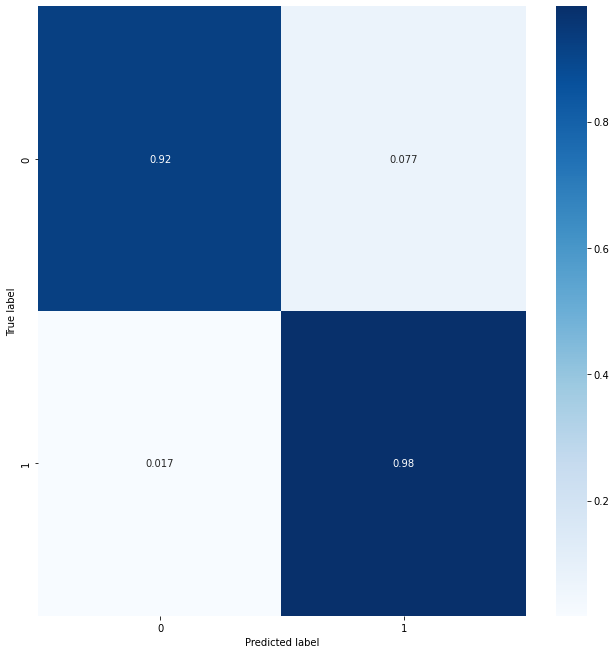

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
def LSTM_block(x):
  '''x = Bidirectional(LSTM(32, activation='selu', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
                           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None, 
                           dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True, go_backwards=True))(x)
  x = Bidirectional(LSTM(32, activation='selu', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
                           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None, 
                           dropout=0.2, recurrent_dropout=0.2, return_state=True, go_backwards=True))(x)'''
  x = Bidirectional(LSTM(16, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
                         recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                         bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None, 
                         dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True, go_backwards=True, name='LSTM_1'))(x)
  x = Bidirectional(LSTM(16, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
                         recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                         bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None, 
                         dropout=0.2, recurrent_dropout=0.2, go_backwards=True, name='LSTM_2'))(x)
  x = Reshape((x.shape[1], 1))(x)
  return x

def dilation_1DCNN_block(x, dilation_rate):
  initializer = tf.keras.initializers.LecunNormal()
  y = Conv1D(filters=8, kernel_size=7, strides=1, padding='causal', dilation_rate=dilation_rate, activation='selu', 
             kernel_initializer=initializer)(x)
  y = Conv1D(filters=8, kernel_size=7, strides=1, padding='causal', dilation_rate=dilation_rate, activation='selu', 
             kernel_initializer=initializer)(y)
  return y

def causal_dilation_1DCNN_block(x):
  initializer = tf.keras.initializers.LecunNormal()
  x = LSTM_block(x)
  x = Conv1D(filters=8, kernel_size=11, strides=1, padding='causal', dilation_rate=1, activation='selu', 
             kernel_initializer=initializer)(x)
  y1 = dilation_1DCNN_block(x, 1)
  x = MaxPool1D(pool_size=2)(x)
  y1 = MaxPool1D(pool_size=2)(y1)
  y2 = dilation_1DCNN_block(Add()([x, y1]), 2)
  y3 = dilation_1DCNN_block(Add()([y1, y2]), 4)
  y4 = dilation_1DCNN_block(Add()([y2, y3]), 8)
  x = Add()([y1, y2, y3, y4])
  x = MaxPool1D(pool_size=2)(x)
  x = Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', dilation_rate=1, activation='selu', 
             kernel_initializer=initializer)(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', dilation_rate=1, activation='tanh', 
             kernel_initializer=initializer)(x)
  x = Dropout(0.1)(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Flatten()(x)
  return x

def channel_wise_attention(x):
  x1 = causal_dilation_1DCNN_block(x[:,0,:,:])
  x2 = causal_dilation_1DCNN_block(x[:,1,:,:])
  x1 = Concatenate()([x1, x2])
  for i in range(2, x.shape[1]):
    x2 = causal_dilation_1DCNN_block(x[:,i,:,:])
    x1 = Concatenate()([x1, x2])
  x = Reshape((x.shape[1], x2.shape[1], 1))(x1)
  y = AvgPool2D(pool_size=(1,x.shape[2]), name='AvgPool2D_1')(x)
  y = Flatten(name='Flatten_1')(y)
  y = Dense(5,activation='tanh', name='Dense_1') (y)
  y = Dense(32,activation='softmax', name='Dense_2') (y)
  x = Multiply(name='Multiply_1')([x, tf.expand_dims(tf.expand_dims(y, axis=2), axis=2)])
  return x

def CNN_LSTM_Self_Attention(x):
  x = Conv2D(filters = 32, kernel_size = (32, 16), strides = (1, 1), padding = 'valid', name = 'Conv2D_1')(x)
  x = BatchNormalization(name='BatchNormalization_1')(x)
  x = Activation('elu', name = 'Activation_1')(x)
  x = MaxPool2D(pool_size=(1, x.shape[2]), name='MaxPool2D_1')(x)
  x = Reshape((1, x.shape[1]*x.shape[2]*x.shape[3]), name='Reshape_1')(x)
  '''x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None, 
           dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True, go_backwards=True, name='LSTM_1')(x)
  x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None, 
           dropout=0.2, recurrent_dropout=0.2, return_sequences=True, go_backwards=True, name='LSTM_2')(x)'''
  y = MultiHeadAttention(num_heads=8, key_dim=8, name = 'MultiHeadAttention_1')(x, x)
  y = Activation('softmax', name = 'Activation_2')(y)
  x = Multiply(name='Multiply_2')([x, y])
  x = Flatten(name='Flatten_2')(x)
  #x = Dense(32, activation='relu', name='Dense_3') (x)
  x = Dense(2, activation='softmax', name='Dense_4') (x)
  return x
